In [1]:
# %%
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

# Forward Model

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
_, pos = util.unpack_fwd(fwd)[1:3]
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s


-- number of adjacent vertices : 1284


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulation

In [3]:
def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(yy / np.max(abs(yy))) for yy in y], axis=0)
    return X, y

settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
X = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
y = np.stack([source.data for source in sim.source_data], axis=0)
X, y = prep_data(X, y)
X = np.swapaxes(X, 1, 2)
y = np.swapaxes(y, 1, 2)
sim.source_data[0].plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 66.60it/s]


# Defs

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda, LayerNormalization, GRU, multiply, Bidirectional
from tensorflow.keras.layers import Activation, Dropout, ActivityRegularization, TimeDistributed, Reshape, Permute, GaussianNoise, add
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
# import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l1, l2, l1_l2
K.set_image_data_format('channels_last')

def data_loss(leadfield, lam_0=0.1):
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    def batch_data_loss(y_true, y_est):
        def d_loss(y_true, y_est):
            y_true_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_true)))
            y_est_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_est)))
            # print("y_true ", y_true)
            # print("y_est ", y_est)
            
            # return K.mean(K.square(y_est - y_true))
            # error_source = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est, y_true)
            # error_eeg = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est_eeg, y_true_eeg)
            error_source =  K.mean(K.square(y_est - y_true))
            error_eeg =  K.mean(K.square(y_est_eeg - y_true_eeg))
            
            return (error_source*lam_0 + error_eeg) / (1 + lam_0)
        
        

        batched_losses = tf.map_fn(lambda x:
            d_loss(x[0], x[1]), 
            (y_true, y_est), dtype=tf.float32)
        return K.mean(batched_losses)


    return batch_data_loss


def consistency(x):
    # error = K.mean(tf.experimental.numpy.diff(K.abs(x), axis=1))
    # error = K.mean(K.abs(x[:,1:])-K.abs(x[:,:-1]))
    error = K.mean(K.square(x[:,1:]-x[:,:-1]))
    # print("error: ", error)
    return error

def c_loss(sources):
    matrix = 1-compute_cosine_distances(K.abs(sources), K.abs(sources))
    return K.mean(matrix)


def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance


def l1_sparsity(x):
    return K.mean(K.abs(x)) 
    # return K.mean(K.pow(K.abs(x), 0.5))


def get_model(name="Model", n_dense_layers=2, n_lstm_units=64, hidden_units=300, learning_rate=0.001, lam_0=0., lam_1=1, lam_2=0.001):
    input_shape = (None, n_chans)
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    inputs = tf.keras.Input(shape=input_shape, name=name)
    fc = TimeDistributed(Dense(hidden_units, activation="tanh", name="FC1"))(inputs)
    source = TimeDistributed(Dense(n_dipoles, activation="tanh", name="Output_Final"))(fc)

    gru = Bidirectional(GRU(n_lstm_units, return_sequences=True, name='GRU_Discriminator'))(inputs)
    source_time = TimeDistributed(Dense(n_dipoles, activation="sigmoid", name="Mask"))(gru)    

    out = multiply([source_time, source])
    
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name=name)
    
    # Data Loss
    # Spatial L1 Regularization
    model.add_loss(l1_sparsity(out)*lam_1)
    # Temporal L2 Regularization
    model.add_loss(consistency(out)*lam_2)
    
    model.compile(loss=data_loss(leadfield, lam_0=lam_0), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Train

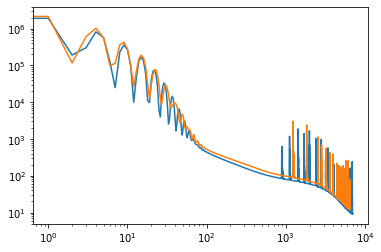

In [40]:
lams_0 = [0.0, 0.0]  # source-based
lams_1 = [1e3, 1e3]  # sparsity
lams_2 = [1e3, 1e4]  # temporal context
epochs = 10000

y_ = np.zeros(y.shape[1:])
callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, min_delta=0.01, monitor="loss")]
models = []
hists = []
for lam_0, lam_1, lam_2 in zip(lams_0, lams_1, lams_2):
    model = get_model(lam_0=lam_0, lam_1=lam_1, lam_2=lam_2, name=f"Lam_{lam_1}")
    hist = model.fit(X[0][np.newaxis], y[0][np.newaxis], epochs=epochs, batch_size=8, callbacks=callbacks, verbose=0)
    models.append(model)
    hists.append(hist)

%matplotlib inline
plt.figure()
for hist in hists:
    plt.loglog(hist.history["loss"])


# Evaluate

No projector specified for this dataset. Please consider the method self.add_proj.


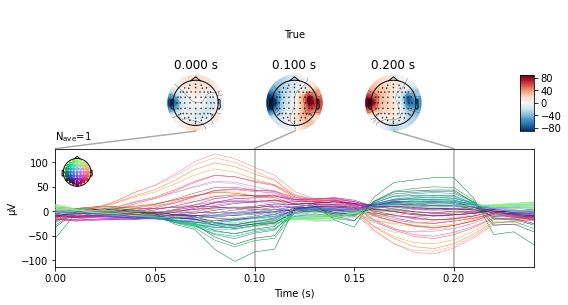

No projector specified for this dataset. Please consider the method self.add_proj.


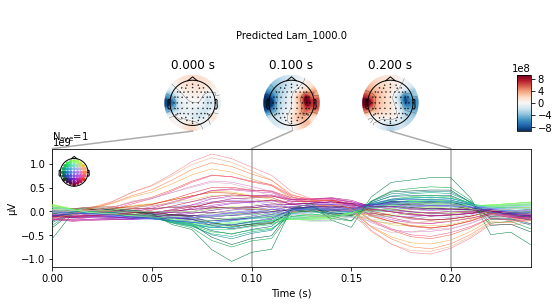

AUC:  0.7000023027173217  Corrs:  0.420789079963725  nMSE:  0.0008682407226474382 Spatial Sparsity:  tf.Tensor(0.008433171, shape=(), dtype=float32) Temporal Sparsity:  tf.Tensor(0.0014787703, shape=(), dtype=float32)
No projector specified for this dataset. Please consider the method self.add_proj.


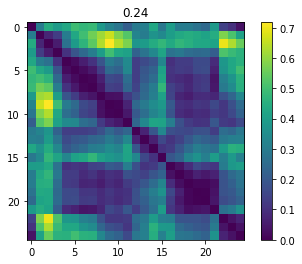

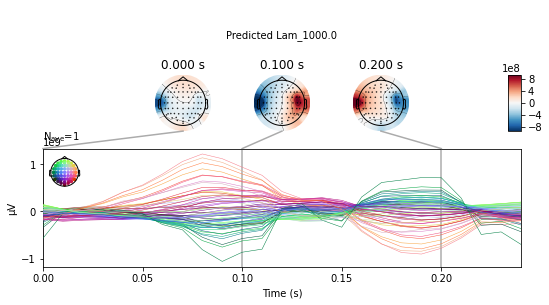

AUC:  0.7289856308724879  Corrs:  0.354755929277974  nMSE:  0.0007550722777748399 Spatial Sparsity:  tf.Tensor(0.00959185, shape=(), dtype=float32) Temporal Sparsity:  tf.Tensor(0.0012994568, shape=(), dtype=float32)


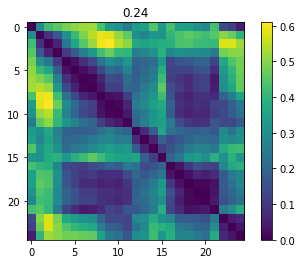

Using control points [0.0481288  0.05667979 0.30340502]
Using control points [0.04323906 0.056138   0.35179195]
Using control points [0.04323906 0.056138   0.35179195]


In [41]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
idx = 0
stc = sim.source_data[idx].copy()
stc.plot(**plot_params)
evoked = sim.eeg_data[idx].average()
evoked.plot_joint(title="True", times=[0, 0.10, 0.20])
for mod in models:
    src_hat = mod.predict(X)[idx]
    stc_hat = stc.copy()
    stc_hat.data = src_hat.T
    stc_hat.plot(**plot_params, brain_kwargs=dict(title=mod.name))

    evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
    evoked_.plot_joint(title=f"Predicted {mod.name}", times=[0, 0.10, 0.20])


    auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    spatial_sparsity = l1_sparsity(stc_hat.data[np.newaxis])
    temporal_sparsity = consistency(stc_hat.data[np.newaxis])
    print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "Spatial Sparsity: ", spatial_sparsity, "Temporal Sparsity: ", temporal_sparsity)
    mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
    plt.figure()
    plt.imshow(mat)
    plt.colorbar()
    plt.title(f"{mat.mean():.2f}")



AUC:  0.7960979508043095  Corrs:  0.35014292815698717  nMSE:  4.129720171930498e-17 Spatial Sparsity:  tf.Tensor(7.58603271463528e-10, shape=(), dtype=float64) Temporal Sparsity:  tf.Tensor(7.726394933798921e-18, shape=(), dtype=float64)


Text(0.5, 1.0, '1.00')

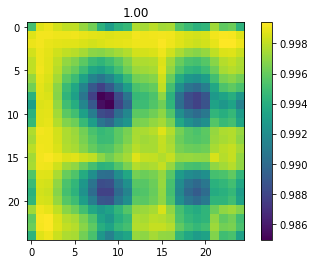

In [47]:
import sys; sys.path.insert(0, "../../invert/")
from invert.solvers.minimum_norm_estimates import SolverMinimumL1Norm
solver = SolverMinimumL1Norm()
solver.make_inverse_operator(fwd)
stc_ = solver.apply_inverse_operator(evoked)
stc_.plot(**plot_params, brain_kwargs=dict(title="L1-FISTA"))

auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_.data.T)])
spatial_sparsity = l1_sparsity(stc_.data[np.newaxis])
temporal_sparsity = consistency(stc_.data[np.newaxis])
print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "Spatial Sparsity: ", spatial_sparsity, "Temporal Sparsity: ", temporal_sparsity)
mat = compute_cosine_distances(abs(stc_.data.T), abs(stc_.data.T)).numpy()
plt.figure()
plt.imshow(mat)
plt.colorbar()
plt.title(f"{mat.mean():.2f}")

In [ ]:
# %%
plt.figure()
plt.imshow(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy())
plt.colorbar()

plt.figure()
plt.imshow(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy())
plt.colorbar()

# %%
plt.figure()
plt.hist(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy().flatten())

plt.figure()
plt.hist(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy().flatten())

# %%
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
# solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])

print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")